# Summary

This notebook is used to generate more data for the main model to use.

This model is trained on (normalized.csv) to be able to predict the roundness of pseudowords.

This is because the original dataset (normalized.csv) only contains 124 rows, and it is insufficient to train a large model like the ByT5-Pseudword-Generator. Hence, this model should learn to predict the roundness values of pseudowords, then be applied on a larger dataset to create a dataset of pseudoword-roundness pairs that will be used to train the ByT5-Pseudword-Generator model.

In [1]:
from utils.roundness_determiner import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import torch
import json


state = 42
VERSION = 2


pd.set_option('display.max_columns', None)
device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(state)

c:\Users\qkm20\anaconda3\envs\pseudoword\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Building and Training

## Dataset

In [2]:
data = pd.read_csv("datasets/normalized.csv")
data

,Stimuli,ExperimentalRoundScore
0,bebi,0.815217
1,bibe,0.913043
2,bobou,0.815217
3,boubo,1.000000
4,chechi,0.184783
...,...,...
119,outou,0.347826
120,uku,0.239130
121,ulu,0.913043
122,umu,0.913043


In [3]:
data.describe()

,ExperimentalRoundScore
count,124.000000
mean,0.562675
std,0.316366
min,0.000000
25%,0.260870
50%,0.543478
75%,0.902174
max,1.000000


In [4]:
from collections import defaultdict

# Initialize a dictionary to store the total score and count for each character
char_scores = defaultdict(lambda: {'total_score': 0, 'count': 0})

# Iterate through each row in the dataframe
for index, row in data.iterrows():
    stimuli = row['Stimuli']
    score = row['ExperimentalRoundScore']
    for char in stimuli:
        char_scores[char]['total_score'] += score
        char_scores[char]['count'] += 1

# Calculate the average score for each character
char_avg_scores = {char: char_scores[char]['total_score'] / char_scores[char]['count'] for char in char_scores}

# Convert to a DataFrame for better visualization
char_avg_scores_df = pd.DataFrame(list(char_avg_scores.items()), columns=['Character', 'AverageRoundScore'])
char_avg_scores_df = char_avg_scores_df.sort_values(by='AverageRoundScore', ascending=False)
char_avg_scores_df

,Character,AverageRoundScore
12,l,0.888768
0,b,0.885870
13,m,0.882246
3,o,0.694170
9,g,0.660326
5,c,0.638587
6,h,0.638587
4,u,0.632158
14,n,0.619565
16,s,0.614130


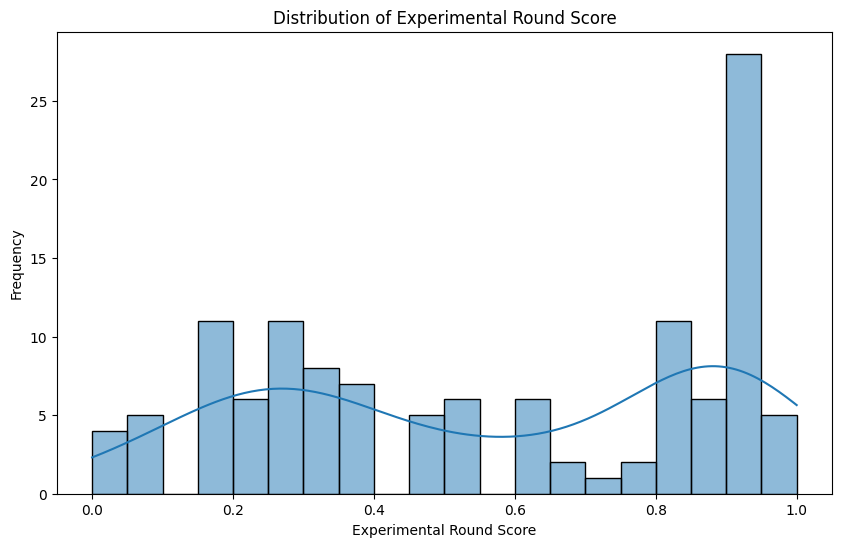

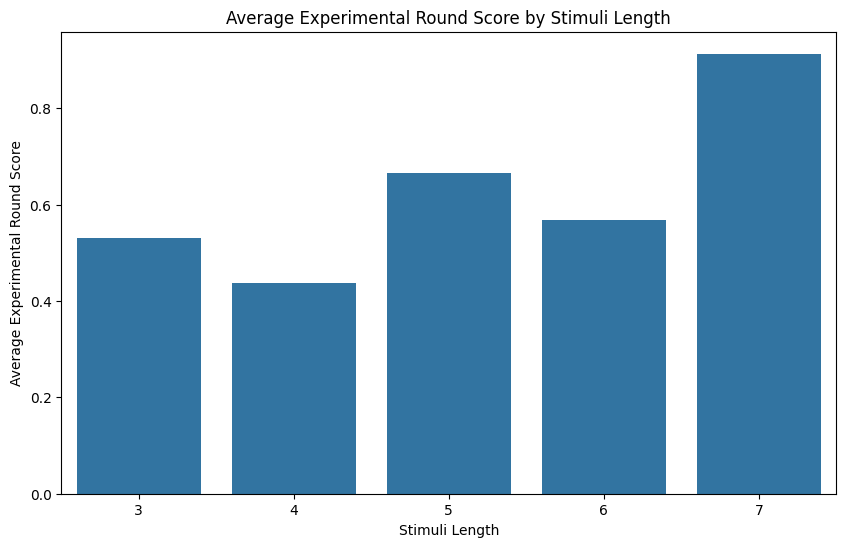

In [5]:
# Distribution of ExperimentalRoundScore
plt.figure(figsize=(10, 6))
sns.histplot(data['ExperimentalRoundScore'], bins=20, kde=True)
plt.title('Distribution of Experimental Round Score')
plt.xlabel('Experimental Round Score')
plt.ylabel('Frequency')
plt.show()

# Average ExperimentalRoundScore by Stimuli length
data['StimuliLength'] = data['Stimuli'].apply(len)
avg_score_by_length = data.groupby('StimuliLength')['ExperimentalRoundScore'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='StimuliLength', y='ExperimentalRoundScore', data=avg_score_by_length)
plt.title('Average Experimental Round Score by Stimuli Length')
plt.xlabel('Stimuli Length')
plt.ylabel('Average Experimental Round Score')
plt.show()

In [6]:
# Split data into train and val

trn = data.sample(frac=0.8, random_state=state)
val = data.drop(trn.index)
trn.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

In [7]:
print(f"Train set: {len(trn)} samples, Validation set: {len(val)} samples")

Train set: 99 samples, Validation set: 25 samples


## Model

In [8]:
model = roundness_determiner()

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

## Training

In [10]:
result = train(
    model=model,
    trn_roundness=trn["ExperimentalRoundScore"],
    trn_texts=trn["Stimuli"],
    val_roundness=val["ExperimentalRoundScore"],
    val_texts=val["Stimuli"],
    batch_size=5,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=1000,
    patience=10,
)

Epoch    1/1000 Train Loss: 4.2467 Val Loss: 1.9257
Epoch    2/1000 Train Loss: 1.2980 Val Loss: 0.9895
Epoch    3/1000 Train Loss: 0.9280 Val Loss: 1.0273
Epoch    4/1000 Train Loss: 0.8599 Val Loss: 1.0023
Epoch    5/1000 Train Loss: 0.7748 Val Loss: 0.8856
Epoch    6/1000 Train Loss: 0.7377 Val Loss: 0.8731
Epoch    7/1000 Train Loss: 0.7533 Val Loss: 0.8984
Epoch    8/1000 Train Loss: 0.7593 Val Loss: 0.9031
Epoch    9/1000 Train Loss: 0.7564 Val Loss: 0.8930
Epoch   10/1000 Train Loss: 0.7502 Val Loss: 0.8818
Epoch   11/1000 Train Loss: 0.7505 Val Loss: 0.8582
Epoch   12/1000 Train Loss: 0.7756 Val Loss: 0.8580
Epoch   13/1000 Train Loss: 0.7922 Val Loss: 0.8542
Epoch   14/1000 Train Loss: 0.8008 Val Loss: 0.8458
Epoch   15/1000 Train Loss: 0.8056 Val Loss: 0.8348
Epoch   16/1000 Train Loss: 0.8178 Val Loss: 0.7279
Epoch   17/1000 Train Loss: 0.8242 Val Loss: 0.6981
Epoch   18/1000 Train Loss: 0.8161 Val Loss: 0.6903
Epoch   19/1000 Train Loss: 0.8056 Val Loss: 0.6884
Epoch   20/1

In [11]:
result = train_kfold(
    model=model,
    roundness=data["ExperimentalRoundScore"],
    texts=data["Stimuli"],
    batch_size=5,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=100,
    patience=10,
)


Fold 1/4
Epoch    1/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch    2/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch    3/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch    4/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch    5/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch    6/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch    7/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch    8/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch    9/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch   10/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch   11/100  Train Loss: 0.6695 Val Loss: 0.6611
Epoch   12/100  Train Loss: 0.6695 Val Loss: 0.6611
Early stopping triggered at epoch 12

Fold 2/4
Epoch    1/100  Train Loss: 0.6926 Val Loss: 0.5917
Epoch    2/100  Train Loss: 0.6926 Val Loss: 0.5917
Epoch    3/100  Train Loss: 0.6926 Val Loss: 0.5917
Epoch    4/100  Train Loss: 0.6926 Val Loss: 0.5917
Epoch    5/100  Train Loss: 0.6926 Val Loss: 0.5917
Epoch    6/100  Train Loss: 0.6926 Val Loss: 0.5917
Epoch  

## Testing

In [12]:
word_list = ["bouba", "kiki"]
model.inference(word_list)

array([0.68376535, 0.43190423], dtype=float32)

In [13]:
word_list = ["maluma", "takete"]
model.inference(word_list)

array([0.2859085, 0.0255878], dtype=float32)

## Saving the model

In [14]:
save_model(
    model=model,
    directory=f"outputs/",
    filename=f"roundness_determiner_v0{VERSION}.pth",
)

Model saved to outputs/roundness_determiner_v02.pth


# Loading and using the model

## Loading the model

In [15]:
model = load_model(directory="outputs/", filename=f"roundness_determiner_v0{VERSION}.pth")

Model loaded from outputs/roundness_determiner_v02.pth


f:\OneDrive - Nanyang Technological University\FYP\Pseudoword-Generator\utils\roundness_determiner.py:330: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dic

In [16]:
word_list = ["bouba", "kiki"]
model.inference(word_list)

array([0.68376565, 0.4319044 ], dtype=float32)

In [17]:
word_list = ["maluma", "takete"]
model.inference(word_list)

array([0.2859081 , 0.02558782], dtype=float32)

## Importing data

In [18]:
# Import data
data = json.load(open("datasets/words.json"))

# Function to generate a random string from data
def generate_random_string(data, min_len=2, max_len=5):
    length = random.randint(min_len, max_len)
    return ''.join(random.choices(list(data.keys()), k=length))

# Generate 5000 unique strings
unique_strings = set()
while len(unique_strings) < 10000:
    unique_strings.add(generate_random_string(data))

# Convert to DataFrame
data = pd.DataFrame(list(unique_strings), columns=['Pseudoword'])
data

,Pseudoword
0,toyaun
1,bineribuu
2,zafugaho
3,podo
4,nteno
...,...
9995,jitakupore
9996,gokeza
9997,mana
9998,sabizamon


## Applying model

In [19]:
data["Roundness"] = model.inference(data["Pseudoword"].to_list())
data

,Pseudoword,Roundness
0,toyaun,0.025297
1,bineribuu,0.999838
2,zafugaho,0.984310
3,podo,0.191057
4,nteno,0.796121
...,...,...
9995,jitakupore,0.998109
9996,gokeza,0.137229
9997,mana,0.403694
9998,sabizamon,0.999407


In [20]:
data.describe()

,Roundness
count,10000.000000
mean,0.692622
std,0.317500
min,0.004033
25%,0.435884
50%,0.797849
75%,0.993706
max,1.000000


## Saving CSV

In [21]:
data.to_csv("datasets/japanese_pseudowords.csv", index=False)